# CS 39AA - Notebook I: Airline Tweets w/ MLP 


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_notebooks/blob/main/nb_C_airline_tweets_take2.ipynb)



In [864]:
import torch
import random
import matplotlib

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [865]:
data_URL = 'https://raw.githubusercontent.com/sgeinitz/cs39aa_notebooks/main/data/trainA.csv'
df = pd.read_csv(data_URL)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head(10)

df.shape: (10000, 2)


,sentiment,text
0,positive,@JetBlue @JayVig I like the inflight snacks! I'm flying with you guys on 2/28! #JVMChat
1,positive,@VirginAmerica thanks guys! Sweet route over the Rockies #airplanemodewason
2,negative,@USAirways Your exchange/credit policies are worthless and shadier than the White House. Dissatisfied to the nines right now.
3,negative,@USAirways but in the meantime I'll be sleeping on a park bench on dadeland st. Thanks guys!
4,negative,@VirginAmerica hold times at call center are a bit much
5,negative,@USAirways not moving we are in the tarmac delayed for some unknown reason. I'll keep you posted
6,neutral,"@JetBlue What about if I booked it through Orbitz? My email is correct, but there's a middle party."
7,negative,@united 2nd flight also delayed no pilots! But they boarded is so we can just sit here! #scheduling
8,negative,".@AmericanAir after 50 minutes on hold, and another 30 minutes on the call yes. Going to be pushing it to get to the airport on time now"
9,positive,@JetBlue flight 117. proud to fly Jet Blue!


In [866]:
random.seed(2) 
indices = list(range(len(df)))
random.shuffle(indices)

df_test = df.iloc[indices[9000:],]
df = df.iloc[indices[:9000],]

In [867]:
df_test.shape
df.shape

(9000, 2)

Recall that about 2/3 of the data have negative labels, and that the remaining labels are roughly split between positive and neutral (slightly more neutral than positive). 

In [868]:
df.sentiment.value_counts(normalize=True)

negative    0.653556
neutral     0.191111
positive    0.155333
Name: sentiment, dtype: float64

Let's start with the nltk TweetTokenizer, which will split the text into separate words and characters based on common Twitter conventions. 

In [869]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer()
df['tokens_raw'] = df['text'].apply(lambda x: tk.tokenize(x.lower()))
df.head()

,sentiment,text,tokens_raw
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, i, ended, up, on, a, flight, to, la, my, fourth, time, on, standby, ., thanks, !, http://t.co/na5g5eakpa]"
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, !, i, only, loose, ', em, at, airports, ..., 1st, time, we, found, it, ., i, think, @fitbit, needs, to, make, flexes, that, stay, on, when, carrying, bags, !]"
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, can, take, u, to, midway-chicago, march, 8th, -, april, 6th, ., can't, make, it, then, ?, @americanair, can, get, u, to, @fly2ohare, year, round, ., #flypbi]"
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, is, this, how, you, let, your, employees, treat, your, loyal, customers, ?, #attackingbabymomma, #crazinessintherockies]"
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, so, i, still, need, to, stay, on, hold, ?, http://t.co/04sdytt7zd]"


Next, let's remove common stop words (e.g. "_the_", "_in_", etc.). In this next cell we will also remove some characters/punctuation, as well as hashtag tokens. 

In [870]:
import re
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))
chars2remove = set(['.','!','/', '?'])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^http', w)]) # remove web links
#df['tokens_raw'] = df['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^@', w)]) # remove web links

df.head()

,sentiment,text,tokens_raw
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, ended, flight, la, fourth, time, standby, thanks, http://t.co/na5g5eakpa]"
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, loose, ', em, airports, ..., 1st, time, found, think, @fitbit, needs, make, flexes, stay, carrying, bags]"
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]"
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, let, employees, treat, loyal, customers]"
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]"


For the final step of text pre-processing we will lemmatize the tokens. Note that there are much better ways to do this but that we want to use a simple lemmatizer. For example, some lemmatizers also utilize a model internally to predict the part-of-speech for each word, since whether the word is a noun, adjective, verb, etc. will affect how lemmatization is done. Since we want to keep things simple here, and focus only on the lemmatization step, we'll assume every word is the same part of speech. Note that this is not by any means ideal (try to identify the incorrectly lemmatized token in the five tweets printed out below). In practice we would certainly utilize a 'smarter' lemmatizer .

In [871]:
from nltk.stem import WordNetLemmatizer
# also need to run following one time on your system (can be done outside of this notebook)
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
#df['tokens'] = df['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.head()

,sentiment,text,tokens_raw,tokens
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, ended, flight, la, fourth, time, standby, thanks, http://t.co/na5g5eakpa]","[@americanair, end, flight, la, fourth, time, standby, thank, http://t.co/na5g5eakpa]"
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, loose, ', em, airports, ..., 1st, time, found, think, @fitbit, needs, make, flexes, stay, carrying, bags]","[@jetblue, thank, loose, ', em, airports, ..., 1st, time, find, think, @fitbit, need, make, flex, stay, carry, bag]"
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]","[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]"
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, let, employees, treat, loyal, customers]","[@americanair, let, employees, treat, loyal, customers]"
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]","[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]"


Since each tweet is currently stored as a string we then created a new column that was a list of each of the words in the tweet (since the default delimiter is a space character). Next, we created a vocabularly sorted by frequency for the full dataset, the subset of positive tweets, negative tweets, and neutral tweets. 

The input to the sklearn vectorizer function requires that each observation (i.e. tweet) is in the form of a string, rather than a list of tokens. So we first need to combine the individual tokens for each tweet back into a string, which we do here:

In [872]:
df['textclean'] = df['tokens'].apply(lambda x: ' '.join(x))
df.head()

,sentiment,text,tokens_raw,tokens,textclean
7010,positive,@AmericanAir I ended up on a flight to LA my fourth time on standby. Thanks! http://t.co/NA5G5EAKPA,"[@americanair, ended, flight, la, fourth, time, standby, thanks, http://t.co/na5g5eakpa]","[@americanair, end, flight, la, fourth, time, standby, thank, http://t.co/na5g5eakpa]",@americanair end flight la fourth time standby thank http://t.co/na5g5eakpa
9477,neutral,@JetBlue thanks! I only loose 'em at airports...1st time we found it. I think @fitbit needs to make flexes that stay on when carrying bags!,"[@jetblue, thanks, loose, ', em, airports, ..., 1st, time, found, think, @fitbit, needs, make, flexes, stay, carrying, bags]","[@jetblue, thank, loose, ', em, airports, ..., 1st, time, find, think, @fitbit, need, make, flex, stay, carry, bag]",@jetblue thank loose ' em airports ... 1st time find think @fitbit need make flex stay carry bag
4584,neutral,@SouthwestAir can take u to Midway-Chicago March 8th-April 6th. Can't make it then? @AmericanAir can get u to @fly2ohare year round. #FlyPBI,"[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]","[@southwestair, take, u, midway-chicago, march, 8th, -, april, 6th, can't, make, @americanair, get, u, @fly2ohare, year, round]",@southwestair take u midway-chicago march 8th - april 6th can't make @americanair get u @fly2ohare year round
3460,negative,@AmericanAir is this how you let your employees treat your loyal customers? #attackingbabymomma #crazinessintherockies,"[@americanair, let, employees, treat, loyal, customers]","[@americanair, let, employees, treat, loyal, customers]",@americanair let employees treat loyal customers
9065,negative,@USAirways so I still need to stay on hold? http://t.co/04SDytT7zd,"[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]","[@usairways, still, need, stay, hold, http://t.co/04sdytt7zd]",@usairways still need stay hold http://t.co/04sdytt7zd


Now we will load the term-frequency inverse-document-frequency vectorizer from sklearn, `TfidfVectorizer`, to convert each tweet into a vector. We'll go ahead and call the resulting vectorized data, `X`, or `X_train` since it is only the training dataset. As with conventional statistical models, "_X_" represents the set of predictors, or independent variables. 

Also, note that `TfidfVectorizer` is a powerful text processing object. It has the ability to remove stop words, strip symbols, and do much of the work that our manual tokenization did. As such, we could easily use the original tweet text here, but we'll go ahead and continue with our manually tokenized data in the column, `textclean`. 

In [873]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
X_np = tfidf_vectorizer.fit_transform(df['textclean']).toarray()

print(f"X_np.shape = {X_np.shape}")
type(X_np)

X_np.shape = (9000, 9008)


numpy.ndarray

In [874]:
X[:3,:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [875]:
X = torch.tensor(X_np).float()
X.size()

torch.Size([9000, 9008])

In [876]:
labels = df['sentiment'].unique()
enum_labels = enumerate(labels)
label_to_idx = dict((lab, i) for i,lab in enum_labels)
print(f"label dictionary: {label_to_idx}")
y = torch.tensor([label_to_idx[lab] for lab in df['sentiment']])

label dictionary: {'positive': 0, 'neutral': 1, 'negative': 2}


In [877]:
class AirlineTweetDataset(Dataset):
    def __init__(self, observations, labels):
        self.obs = observations
        self.labs = labels
        self.create_split(len(observations))

    def create_split(self, n, seed=1, train_perc=0.7):
        random.seed(seed)
        indices = list(range(n))
        random.shuffle(indices)
        self._train_ids = list(indices[:int(n * train_perc)])
        self._test_ids = list(indices[int(n * train_perc):])
        self._split_X = self.obs[self._train_ids]
        self._split_y = self.labs[self._train_ids]

    def set_split(self, split='train'):
        if split == 'train':
            self._split_X = self.obs[self._train_ids]
            self._split_y = self.labs[self._train_ids]
        else:
            self._split_X = self.obs[self._test_ids]
            self._split_y = self.labs[self._test_ids]

    def __len__(self):
        return len(self._split_y)

    def __getitem__(self, idx):
        return {'x':self._split_X[idx], 'y':self._split_y[idx]}

dataset = AirlineTweetDataset(X, y)
dataset.create_split(len(X), seed=42, train_perc=0.85)

In [878]:
dataset.set_split('train')
print(f"len(dataset) = {len(dataset)}")
#len(dataset[:]['x'])
dataset[0]['x']

len(dataset) = 7650


tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [879]:
assert not np.any(np.isnan(dataset[:]['x'].numpy()))
assert np.all(np.isfinite(dataset[:]['x'].numpy()))

In [880]:
class AirlineTweetClassifier(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input embeddings
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(AirlineTweetClassifier, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 16)
        self.fc3 = nn.Linear(16, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))

        intermediate_vector = F.relu(self.fc2(intermediate_vector))
        intermediate_vector = self.dropout(intermediate_vector)

        prediction_vector = self.fc3(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

In [881]:
batch_size = 100
learning_rate = 0.001 # 0.005
num_epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [882]:
dataset.set_split('train')
print(len(dataloader) * batch_size)
dataset.set_split('val')
print(len(dataloader) * batch_size)

7700
1400


In [883]:
model = AirlineTweetClassifier(len(dataset[0]['x']), 32, 3)

# define loss function and optimizer
#weights = 1 / torch.tensor([15.0, 65.0, 20.0])
loss_fun = nn.CrossEntropyLoss()#weights)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [884]:
seed = 2
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [885]:
losses = {'train':[], 'val':[]}

for epoch in range(num_epochs):

    model.train()
    running_loss_train = 0.0

    dataset.set_split('train')
    for batch_i, batch_data in enumerate(train_loader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        
        # forward
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['train'].append(loss.item())
        running_loss_train += loss.item()
        	
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        #if (batch_i+1) % 200 == 0:
        #    print(f"    train batch {batch_i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")
        
    running_loss_train = running_loss_train / len(dataset)

    dataset.set_split('val')
    model.eval() # turn off the automatic differentiation 
    running_loss_val = 0.0

    for batch_i, batch_data in enumerate(val_loader):  
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)

        
        # forward (no backward step for validation data)
        outputs = model(tweets)
        loss = loss_fun(outputs, labels)
        losses['val'].append(loss.item())
        running_loss_val += loss.item()
        #if (i+1) % 50 == 0:
        #    print(f"    valid batch {i+1:3.0f} (of {len(dataloader):3.0f}) loss: {loss.item():.4f}")

    running_loss_val = running_loss_val / len(dataset)
    print(f"Epoch {epoch+1} (of {num_epochs}): mean train loss = {running_loss_train:.4f}, mean val loss = {running_loss_val:.4f}")

Epoch 1 (of 100): mean train loss = 0.0033, mean val loss = 0.0180
Epoch 2 (of 100): mean train loss = 0.0031, mean val loss = 0.0170
Epoch 3 (of 100): mean train loss = 0.0029, mean val loss = 0.0156
Epoch 4 (of 100): mean train loss = 0.0026, mean val loss = 0.0136
Epoch 5 (of 100): mean train loss = 0.0023, mean val loss = 0.0116
Epoch 6 (of 100): mean train loss = 0.0020, mean val loss = 0.0102
Epoch 7 (of 100): mean train loss = 0.0017, mean val loss = 0.0083
Epoch 8 (of 100): mean train loss = 0.0014, mean val loss = 0.0068
Epoch 9 (of 100): mean train loss = 0.0012, mean val loss = 0.0058
Epoch 10 (of 100): mean train loss = 0.0010, mean val loss = 0.0050
Epoch 11 (of 100): mean train loss = 0.0009, mean val loss = 0.0045
Epoch 12 (of 100): mean train loss = 0.0008, mean val loss = 0.0038
Epoch 13 (of 100): mean train loss = 0.0007, mean val loss = 0.0033
Epoch 14 (of 100): mean train loss = 0.0006, mean val loss = 0.0028
Epoch 15 (of 100): mean train loss = 0.0005, mean val los

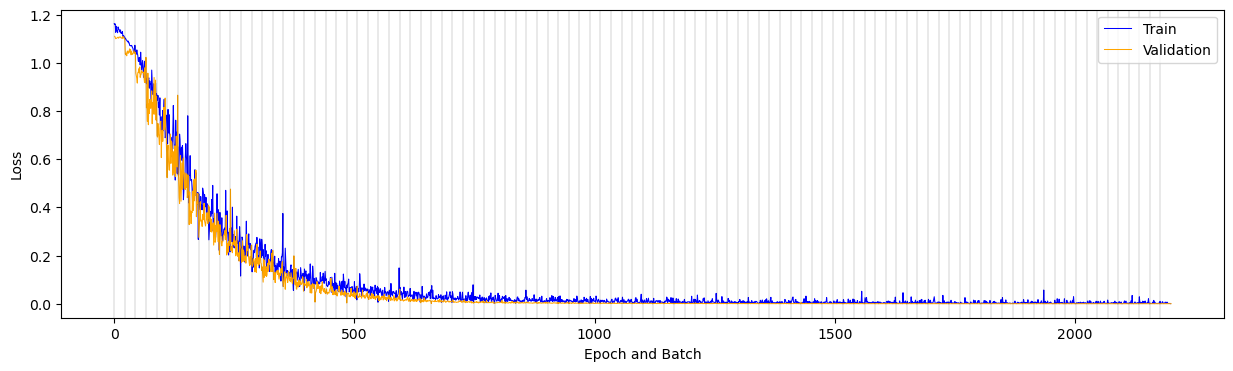

In [886]:
matplotlib.rc('figure', figsize=(15,4))
val_ticks = [(i+1)*len(losses['train'])/len(losses['val']) for i in range(len(losses['val']))]
plt.plot(range(len(losses['train'])), losses['train'], c='blue', lw=0.75)
plt.plot(val_ticks, losses['val'], c='orange', lw=0.75)
for i in range(num_epochs):
    plt.axvline(x=i*len(losses['train'])/num_epochs, c='black', lw=0.25, alpha=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

In [887]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in val_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(val_loader)*batch_size} validation tweets): {100 * correct / total:.2f}%")
	 

Accuracy (on 2200 validation tweets): 100.00%


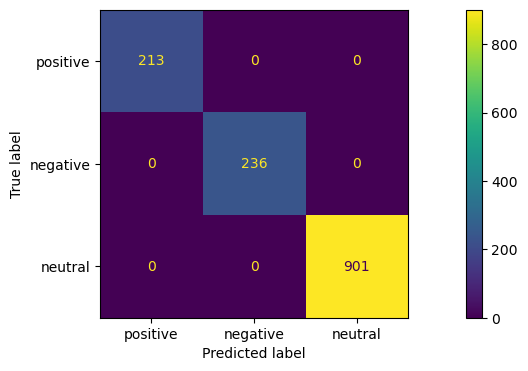

In [888]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','negative','neutral'])
disp.plot()

In [889]:
import torchsummary
torchsummary.summary(model, tuple(dataset[0]['x'].size()))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]         288,288
            Linear-2                   [-1, 16]             528
           Dropout-3                   [-1, 16]               0
            Linear-4                    [-1, 3]              51
Total params: 288,867
Trainable params: 288,867
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.00
Params size (MB): 1.10
Estimated Total Size (MB): 1.14
----------------------------------------------------------------


In [890]:
9555*32 + 32

305792

In [891]:
df_test.head(10)

,sentiment,text
7391,negative,"Why even ask me to DM you and offer help if you ""can't do anything"" @united #terriblecustomerservice #unitedairlines http://t.co/feC4i3Vwq7"
6692,negative,@USAirways Do you have any pride in your service? Any concerns for my wife and everyone else on that flight? Or you just don't care????!!!
2849,negative,@USAirways Would you guys please send service agents to gate B15 in Philly? All the people missed there connections and there's only 2.
3824,negative,@JetBlue apparently the plane was delayed coming up from San Juan. Monsoon there today?
9386,negative,@JetBlue This is the error message: Paper tickets cannot be serviced on-line.\nPlease see a JetBlue Crewmember for assistance.
2712,neutral,@JetBlue's new CEO seeks the right balance to please passengers and Wall ... - Alaska Highway News http://t.co/tynchOeLac
5714,neutral,@united mine is GJQX6J husband is A587CW (Can't DM for some reason.)
5943,negative,@AmericanAir I want to speak to a human being! !! This is not an obscene request!
7414,negative,@JetBlue appreciate the response Worst part is losing the non refundable hotel in Orlando. Your crew blamed wind! Hoping for no more delays!
6398,negative,@united I have and been denied! I called and got hung up on. Did speaks with manager on second call


In [892]:
tk = TweetTokenizer()
df_test['tokens_raw'] = df_test['text'].apply(lambda x: tk.tokenize(x.lower()))
df_test.head()

,sentiment,text,tokens_raw
7391,negative,"Why even ask me to DM you and offer help if you ""can't do anything"" @united #terriblecustomerservice #unitedairlines http://t.co/feC4i3Vwq7","[why, even, ask, me, to, dm, you, and, offer, help, if, you, "", can't, do, anything, "", @united, #terriblecustomerservice, #unitedairlines, http://t.co/fec4i3vwq7]"
6692,negative,@USAirways Do you have any pride in your service? Any concerns for my wife and everyone else on that flight? Or you just don't care????!!!,"[@usairways, do, you, have, any, pride, in, your, service, ?, any, concerns, for, my, wife, and, everyone, else, on, that, flight, ?, or, you, just, don't, care, ?, ?, ?, !, !, !]"
2849,negative,@USAirways Would you guys please send service agents to gate B15 in Philly? All the people missed there connections and there's only 2.,"[@usairways, would, you, guys, please, send, service, agents, to, gate, b15, in, philly, ?, all, the, people, missed, there, connections, and, there's, only, 2, .]"
3824,negative,@JetBlue apparently the plane was delayed coming up from San Juan. Monsoon there today?,"[@jetblue, apparently, the, plane, was, delayed, coming, up, from, san, juan, ., monsoon, there, today, ?]"
9386,negative,@JetBlue This is the error message: Paper tickets cannot be serviced on-line.\nPlease see a JetBlue Crewmember for assistance.,"[@jetblue, this, is, the, error, message, :, paper, tickets, cannot, be, serviced, on-line, ., please, see, a, jetblue, crewmember, for, assistance, .]"


In [893]:
df_test['tokens_raw'] = df_test['tokens_raw'].apply(lambda x: [w for w in x if w not in stops])
df_test['tokens_raw'] = df_test['tokens_raw'].apply(lambda x: [w for w in x if w not in chars2remove])
df_test['tokens_raw'] = df_test['tokens_raw'].apply(lambda x: [w for w in x if not re.match('^#', w)]) # remove hashtags

df_test.head()

,sentiment,text,tokens_raw
7391,negative,"Why even ask me to DM you and offer help if you ""can't do anything"" @united #terriblecustomerservice #unitedairlines http://t.co/feC4i3Vwq7","[even, ask, dm, offer, help, "", can't, anything, "", @united, http://t.co/fec4i3vwq7]"
6692,negative,@USAirways Do you have any pride in your service? Any concerns for my wife and everyone else on that flight? Or you just don't care????!!!,"[@usairways, pride, service, concerns, wife, everyone, else, flight, care]"
2849,negative,@USAirways Would you guys please send service agents to gate B15 in Philly? All the people missed there connections and there's only 2.,"[@usairways, would, guys, please, send, service, agents, gate, b15, philly, people, missed, connections, there's, 2]"
3824,negative,@JetBlue apparently the plane was delayed coming up from San Juan. Monsoon there today?,"[@jetblue, apparently, plane, delayed, coming, san, juan, monsoon, today]"
9386,negative,@JetBlue This is the error message: Paper tickets cannot be serviced on-line.\nPlease see a JetBlue Crewmember for assistance.,"[@jetblue, error, message, :, paper, tickets, cannot, serviced, on-line, please, see, jetblue, crewmember, assistance]"


In [894]:
df_test['tokens'] = df_test['tokens_raw'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
df_test['textclean'] = df_test['tokens'].apply(lambda x: ' '.join(x))

X_test_int = tfidf_vectorizer.transform(df_test['textclean']).toarray() # be sure that we are using .transform() here, and not .fit_transform()

print(f"X_test_int.shape = {X_test_int.shape}")
type(X_test_int)

X_test_int.shape = (1000, 9008)


numpy.ndarray

In [895]:
X_test = torch.tensor(X_test_int).float()
X_test.size()

torch.Size([1000, 9008])

In [896]:
y_test = torch.tensor([label_to_idx[lab] for lab in df_test['sentiment']])

In [897]:
test_dataset = AirlineTweetDataset(X_test, y_test)
test_dataset.create_split(len(X_test), seed=42, train_perc=1.0)

In [898]:
len(test_dataset)

1000

In [899]:
test_dataset[999]

{'x': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'y': tensor(2)}

In [900]:
bs = 500
test_loader = DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [901]:
y_true = []
y_pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for batch_data in test_loader:
        tweets = batch_data['x'].to(device)
        labels = batch_data['y'].to(device)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy (on {len(test_loader)*bs} test tweets): {100 * correct / total:.2f}%")

Accuracy (on 1000 test tweets): 74.70%


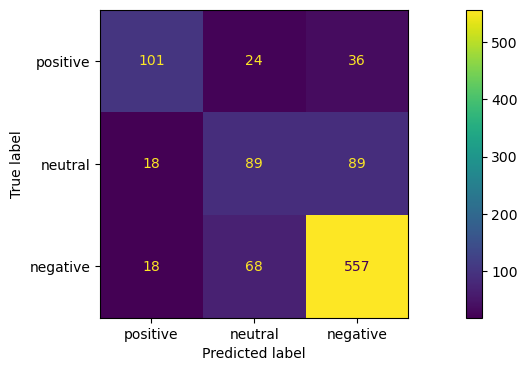

In [902]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['positive','neutral','negative'])
disp.plot()